# Week Ten - Assignment: Document Classification
 
## *Instructions*

*It can be useful to be able to classify new "test" documents using already classified "training" documents.  A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam.  Here is one example of such data:  [UCI Machine Learning Repository: Spambase Data Set](http://archive.ics.uci.edu/ml/datasets/Spambase).*

*For this project, you can either use the above dataset to predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).*

*For more adventurous students, you are welcome (encouraged!) to come up a different set of documents (including scraped web pages!?) that have already been classified (e.g. tagged), then analyze these documents to predict how new documents should be classified.*

## Import the Spambase Dataset

In [ ]:
# Load libraries
import nltk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import zipfile
import io
import requests
from imblearn.under_sampling import RandomUnderSampler

In [3]:
# Download the zip file from the internet
url = "https://archive.ics.uci.edu/static/public/94/spambase.zip"
response = requests.get(url)

# Extract spambase.zip from the downloaded zip
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # Extract spambase.data from spambase.zip
    with z.open('spambase.data') as csvfile:
        spambase_data = pd.read_csv(csvfile, sep=',', header=None)
        
spambase_data.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [9]:
# Rename columns
column_names = [
    "word_freq_make",
    "word_freq_address",
    "word_freq_all",
    "word_freq_3d",
    "word_freq_our",
    "word_freq_over",
    "word_freq_remove",
    "word_freq_internet",
    "word_freq_order",
    "word_freq_mail",
    "word_freq_receive",
    "word_freq_will",
    "word_freq_people",
    "word_freq_report",
    "word_freq_addresses",
    "word_freq_free",
    "word_freq_business",
    "word_freq_email",
    "word_freq_you",
    "word_freq_credit",
    "word_freq_your",
    "word_freq_font",
    "word_freq_000",
    "word_freq_money",
    "word_freq_hp",
    "word_freq_hpl",
    "word_freq_george",
    "word_freq_650",
    "word_freq_lab",
    "word_freq_labs",
    "word_freq_telnet",
    "word_freq_857",
    "word_freq_data",
    "word_freq_415",
    "word_freq_85",
    "word_freq_technology",
    "word_freq_1999",
    "word_freq_parts",
    "word_freq_pm",
    "word_freq_direct",
    "word_freq_cs",
    "word_freq_meeting",
    "word_freq_original",
    "word_freq_project",
    "word_freq_re",
    "word_freq_edu",
    "word_freq_table",
    "word_freq_conference",
    "char_freq_;",
    "char_freq_(",
    "char_freq_[",
    "char_freq_!",
    "char_freq_$",
    "char_freq_#",
    "capital_run_length_average",
    "capital_run_length_longest",
    "capital_run_length_total",
    "spam"
]

spambase_data.columns = column_names
spambase_data.head()


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


## Splitting our data

For our project, we'll split our data into a training and test dataset and balance the data so that there are equal numbers of spam and non-spam emails. We know there are 4,601 observations in this data, 39.4% of which are spam. We split data into 300 emails for the test set, 300 emails for the dev-test set, and the remaining 4,001 emails for the training set.

In [10]:
def split_data(df, verbose=True):
    x = df.drop('spam', axis=1)
    y = df['spam']

    # Split into test (300), dev-test (300), and training (remaining)
    x_temp, x_test, y_temp, y_test = train_test_split(
        x, y, test_size=300, random_state=1, stratify=y    # Stratify to keep spam balance
    )
    x_train, x_devtest, y_train, y_devtest = train_test_split(
        x_temp, y_temp, test_size=300, random_state=1, stratify=y_temp
    )

    # Print a summary of the split data (only if verbose=True)
    if verbose:
        print("\n--- Distribution after Stratified Split ---")
        print("Training set size:", len(y_train))
        print("Dev-test set size:", len(y_devtest))
        print("Test set size:", len(y_test))
        print("\nTraining set counts:", Counter(y_train))
        print("Dev-test set counts:", Counter(y_devtest))
        print("Test set counts:", Counter(y_test))

    rus = RandomUnderSampler(random_state=1)

    # Apply the sampling only to the training set
    x_train_resampled, y_train_resampled = rus.fit_resample(x_train, y_train)

    # Print a summary of the final data (only if verbose=True)
    if verbose:
        print("\n--- Distribution after Undersampling Training Set ---")
        print("New (Balanced) Training set counts:", Counter(y_train_resampled))
        print(f"Total balanced training samples: {len(y_train_resampled)}")
        print("\nDev-test and Test sets (Unmodified for evaluation):")
        print("Dev-test set counts:", Counter(y_devtest))
        print("Test set counts:", Counter(y_test))
    
    # Return all three sets
    return x_train_resampled, x_devtest, x_test, y_train_resampled, y_devtest, y_test

x_train_resampled, x_devtest, x_test, y_train_resampled, y_devtest, y_test = split_data(spambase_data)


--- Distribution after Stratified Split ---
Training set size: 4001
Dev-test set size: 300
Test set size: 300

Training set counts: Counter({0: 2424, 1: 1577})
Dev-test set counts: Counter({0: 182, 1: 118})
Test set counts: Counter({0: 182, 1: 118})

--- Distribution after Undersampling Training Set ---
New (Balanced) Training set counts: Counter({0: 1577, 1: 1577})
Total balanced training samples: 3154

Dev-test and Test sets (Unmodified for evaluation):
Dev-test set counts: Counter({0: 182, 1: 118})
Test set counts: Counter({0: 182, 1: 118})


## Building our models

We'll try the following three models:
1. Naive Bayes Classifier
2. Decision Tree Classifier
3. Maxent Classifier

In [9]:
def train_nltk_classifiers(training_data):
    # I turned this into a function since we'll be iterating
    return(
        {
            'NaiveBayes': nltk.NaiveBayesClassifier.train(training_data),
            'DecisionTree': nltk.DecisionTreeClassifier.train(training_data),
            'MaxentClassifier': nltk.MaxentClassifier.train(training_data, max_iter=10, trace=0)
        }
    )

first_round_bathroom_classifiers = train_nltk_classifiers(train_nltk_data)

print("\n--- Evaluating on dev-test set ---")
for name, classifier in first_round_bathroom_classifiers.items():
    accuracy = nltk.classify.accuracy(classifier, devtest_nltk_data)
    print(f"{name} Dev-Test Accuracy: {accuracy * 100:.2f}%")


--- Evaluating on dev-test set ---
NaiveBayes Dev-Test Accuracy: 75.20%
DecisionTree Dev-Test Accuracy: 34.20%
MaxentClassifier Dev-Test Accuracy: 74.60%


On the first round of models with our feature we find that the Naive Bayes classifier is the best performing with an accuracy of 75.2%.

In [10]:
first_round_bathroom_classifiers['NaiveBayes'].show_most_informative_features(50)

Most Informative Features
    get_two_last_letters = 'na'           female : male   =     90.6 : 1.0
    get_two_last_letters = 'la'           female : male   =     69.0 : 1.0
    get_two_last_letters = 'ia'           female : male   =     52.6 : 1.0
    get_two_last_letters = 'us'             male : female =     36.3 : 1.0
    get_two_last_letters = 'sa'           female : male   =     33.7 : 1.0
    get_two_last_letters = 'ra'           female : male   =     23.6 : 1.0
    get_two_last_letters = 'rd'             male : female =     23.0 : 1.0
    get_two_last_letters = 'ta'           female : male   =     21.4 : 1.0
    get_two_last_letters = 'ld'             male : female =     18.3 : 1.0
    get_two_last_letters = 'do'             male : female =     16.3 : 1.0
    get_two_last_letters = 'io'             male : female =     15.0 : 1.0
    get_two_last_letters = 'ka'           female : male   =     12.3 : 1.0
    get_two_last_letters = 'os'             male : female =     12.3 : 1.0

Looking at the most important 20 features we can see that they're all related to the last two letters of the name. Extending the importance further to 50 features, we found that a vowel proportion of 62.5% also appear in the list.
    
To further improve our model, we can likely engineer more features related to the letters in the names.

## Feature Engineering Iteration 2: First Letter, Name Length, and Longest Consonant Chain
First we saw that the numeric columns we assumed might be useful weren't very informative and thus decided to drop them from our feature set.

In [11]:
iteration_2_df = feature_names_df.drop(columns = ['vowel_proportion', 'first_last_letter', 'longest_run_of_vowels'], errors='ignore')
iteration_2_df.head()

,name,gender,get_two_last_letters
0,Aamir,male,ir
1,Aaron,male,on
2,Abbey,male,ey
3,Abbie,male,ie
4,Abbot,male,ot


For a new set of features, we'll use the first letter of the word and we'll also add in the length of the name as a feature. For the new numeric value, we'll also plot a histogram as we did before.

In [12]:
iteration_2_df['name_length'] = iteration_2_df['name'].apply(len)
iteration_2_df['first_letter'] = iteration_2_df['name'].str[0].str.lower()
iteration_2_df.head()

,name,gender,get_two_last_letters,name_length,first_letter
0,Aamir,male,ir,5,a
1,Aaron,male,on,5,a
2,Abbey,male,ey,5,a
3,Abbie,male,ie,5,a
4,Abbot,male,ot,5,a


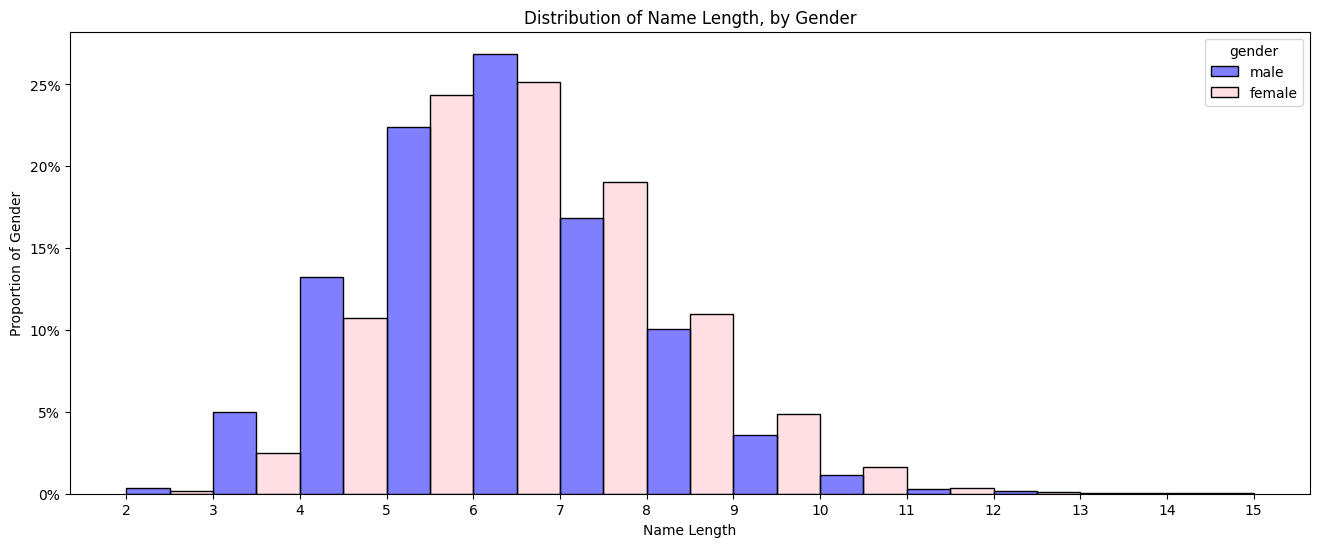

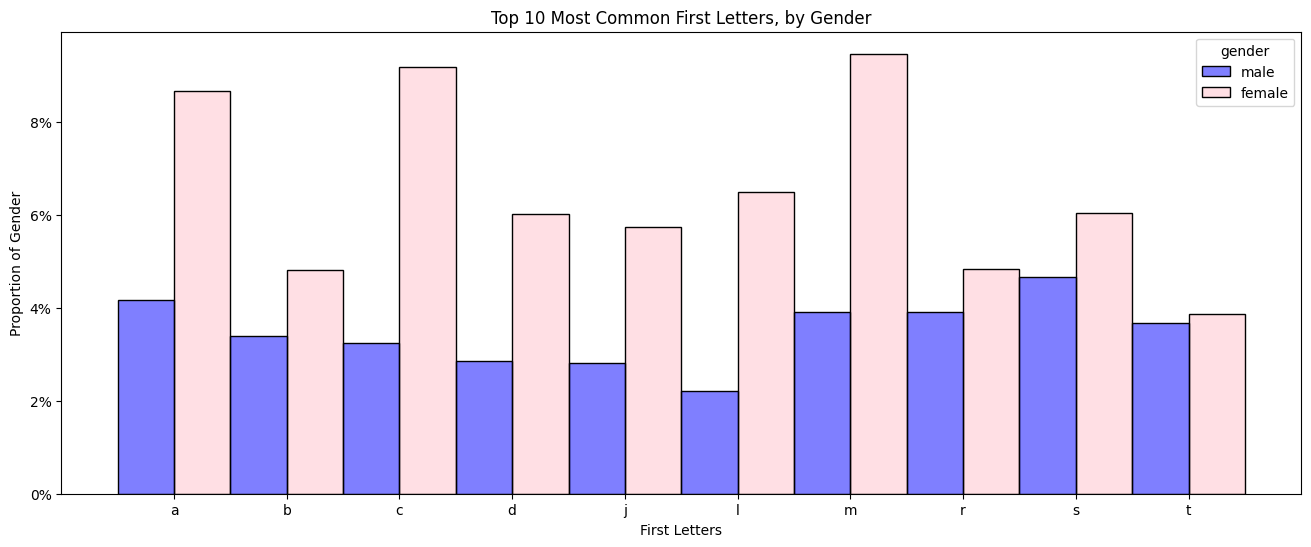

In [13]:
plt.figure(figsize=(16, 6))

sns.histplot(
    data=iteration_2_df,
    x='name_length',
    hue='gender',
    palette=custom_palette,
    stat="proportion",
    multiple='dodge',
    #kde=True,
    alpha=0.5,
    bins=13,
    common_norm=False
)
plt.title('Distribution of Name Length, by Gender')
plt.xlabel('Name Length')
plt.xticks(range(iteration_2_df['name_length'].min(), iteration_2_df['name_length'].max() + 1))
plt.ylabel('Proportion of Gender')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.show()

# Plot for first_letter
plt.figure(figsize=(16, 6))
top_10 = iteration_2_df['first_letter'].value_counts().nlargest(10).index
sns.histplot(
    data=iteration_2_df[iteration_2_df['first_letter'].isin(top_10)],
    x='first_letter',
    hue='gender',
    palette=custom_palette,
    stat="proportion",
    alpha=0.5,
    multiple='dodge'
)
plt.title('Top 10 Most Common First Letters, by Gender')
plt.xlabel('First Letters')
plt.ylabel('Proportion of Gender')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.show()

Name length doesn't seem to provide any information so we'll drop it from our dataset. The first letter seems to have some differences between gender so we'll keep it as a feature.

In [14]:
iteration_2_df = iteration_2_df.drop(columns=['name_length'], errors='ignore')
iteration_2_df.head()

,name,gender,get_two_last_letters,first_letter
0,Aamir,male,ir,a
1,Aaron,male,on,a
2,Abbey,male,ey,a
3,Abbie,male,ie,a
4,Abbot,male,ot,a


In the spirit of trying something new, let's get the longest consonant chain.

In [15]:
def gimme_the_longest_consonant_chain(name: pd.Series) -> pd.Series:
    if not isinstance(name, str):
        return '' # Return empty string for non-string input
    
    consonants = set('bcdfghjklmnpqrstvwxyz')
    name_lower = name.lower()
    
    max_chain_str = ""
    current_chain_str = ""
    
    for char in name_lower:
        if char.isalpha() and char in consonants:
            # Character is a consonant, append it to the current chain string
            current_chain_str += char
        else:
            # Character is a vowel, 'y', or non-alphabetic
            # Check if the current chain is the longest found so far
            if len(current_chain_str) > len(max_chain_str):
                max_chain_str = current_chain_str
            # Reset the current chain string
            current_chain_str = ""
            
    # Important: Check one last time after the loop finishes 
    # (in case the longest chain ends the string)
    if len(current_chain_str) > len(max_chain_str):
        max_chain_str = current_chain_str

    return max_chain_str

iteration_3_df = iteration_2_df.copy()
iteration_3_df['longest_consonant_chain'] = iteration_3_df['name'].apply(gimme_the_longest_consonant_chain)
iteration_3_df.head()


,name,gender,get_two_last_letters,first_letter,longest_consonant_chain
0,Aamir,male,ir,a,m
1,Aaron,male,on,a,r
2,Abbey,male,ey,a,bb
3,Abbie,male,ie,a,bb
4,Abbot,male,ot,a,bb


We plot this below.

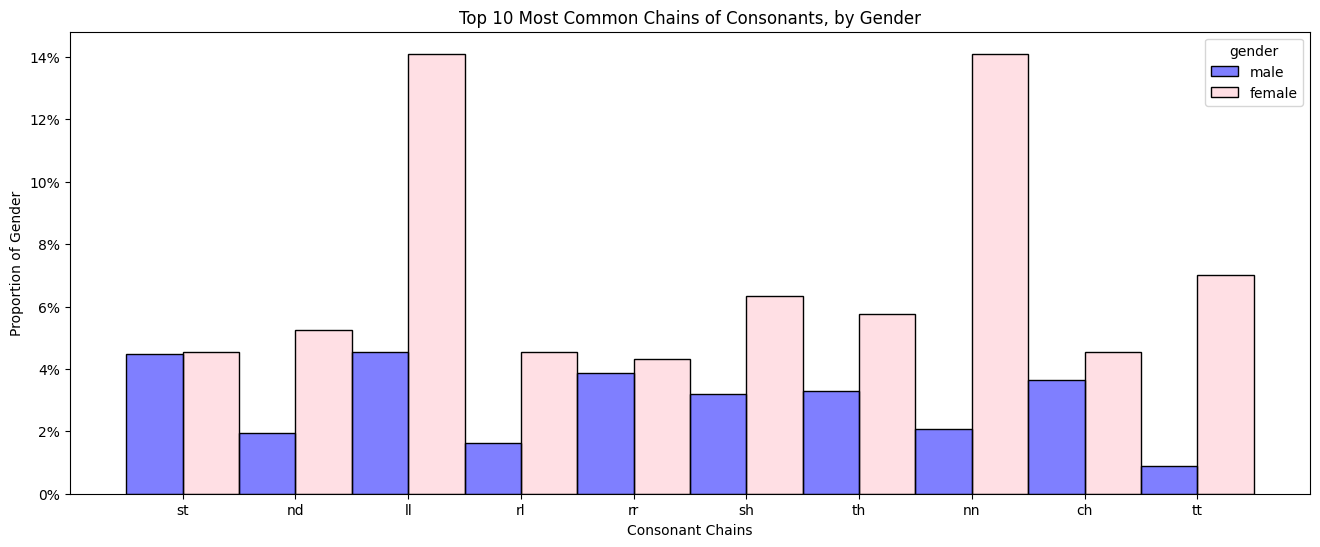

In [16]:
# Plot for longest_consonant_chain
plt.figure(figsize=(16, 6))
top_10 = iteration_3_df[iteration_3_df['longest_consonant_chain'].str.len() > 1]['longest_consonant_chain'].value_counts().nlargest(10).index
sns.histplot(
    data=iteration_3_df[iteration_3_df['longest_consonant_chain'].isin(top_10)],
    x='longest_consonant_chain',
    hue='gender',
    palette=custom_palette,
    stat="proportion",
    alpha=0.5,
    multiple='dodge'
)
plt.title('Top 10 Most Common Chains of Consonants, by Gender')
plt.xlabel('Consonant Chains')
plt.ylabel('Proportion of Gender')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.show()

There appear to be a high proportion of girls names with two "l"s or "n"s in a row. 

With these new features, we'll try classifying the names again and see how well the models perform.

In [17]:
# We'll define a new function to just pass the dataframe and do all of the previous steps
def dataframe_to_classifiers(df, training_cycle_name):
    # Split the data (suppress verbose output)
    x_train_resampled, x_devtest, x_test, y_train_resampled, y_devtest, y_test = split_data_for_nltk(df, verbose=False)
    
    # Convert to NLTK format
    train_nltk_data = prepare_data_for_nltk(x_train_resampled, y_train_resampled)
    devtest_nltk_data = prepare_data_for_nltk(x_devtest, y_devtest)
    test_nltk_data = prepare_data_for_nltk(x_test, y_test)

    # Train all three classifiers with the new features
    classifiers = train_nltk_classifiers(train_nltk_data)
    
    print(f"\n--- Results for {training_cycle_name} (on DEV-TEST set) ---")

    best_classifier = None
    best_classifier_name = None
    best_accuracy = 0

    # Evaluate each classifier on dev-test set
    for name, classifier in classifiers.items():
        accuracy = nltk.classify.accuracy(classifier, devtest_nltk_data)
        print(f"{name} Dev-Test Accuracy: {accuracy * 100:.2f}%")
        
        if accuracy > best_accuracy:
            best_classifier = classifier
            best_classifier_name = name
            best_accuracy = accuracy

    print(f"\nThe best classifier is {best_classifier_name} with a dev-test accuracy of {best_accuracy * 100:.2f}%\n")
    best_classifier.show_most_informative_features(20)
    
    # Return both dev-test and test sets (NLTK format) along with the chosen classifier.
    # This avoids relying on global variables later and makes the evaluation explicit.
    return devtest_nltk_data, test_nltk_data, best_classifier

# Run iteration 3 with new features
# Capture both dev-test and test NLTK datasets plus the chosen classifier so
# final evaluation uses the exact splits produced during this run.
devtest_data_final, test_data_final, best_classifier = dataframe_to_classifiers(
    iteration_3_df,
    "Last Two Letters, First Letter, & Longest Consonant Chain"
)



--- Results for Last Two Letters, First Letter, & Longest Consonant Chain (on DEV-TEST set) ---
NaiveBayes Dev-Test Accuracy: 79.60%
DecisionTree Dev-Test Accuracy: 34.20%
MaxentClassifier Dev-Test Accuracy: 78.00%

The best classifier is NaiveBayes with a dev-test accuracy of 79.60%

Most Informative Features
    get_two_last_letters = 'na'           female : male   =     90.6 : 1.0
    get_two_last_letters = 'la'           female : male   =     69.0 : 1.0
    get_two_last_letters = 'ia'           female : male   =     52.6 : 1.0
    get_two_last_letters = 'us'             male : female =     36.3 : 1.0
    get_two_last_letters = 'sa'           female : male   =     33.7 : 1.0
    get_two_last_letters = 'ra'           female : male   =     23.6 : 1.0
    get_two_last_letters = 'rd'             male : female =     23.0 : 1.0
    get_two_last_letters = 'ta'           female : male   =     21.4 : 1.0
    get_two_last_letters = 'ld'             male : female =     18.3 : 1.0
    get_two_

The Naive Bayes Classifier remains the best model choice, performing slightly better than our first model with a minor improvement in accuracy from correctly predicting 75.2% of genders in the test set to 79.6%. The last 2 letters remain the most informative feature in the data, but we can now see that consonant runs like "rv", "rk", and "lt" are important for predicting male names, and "lyn" can help predict female names.

## Final Evaluation on Test Set

Now that we're satisfied with our best model from the two dev test iterations, we evaluate it on the held-out test set to get a final estimate of "real-world" performance.

In [18]:
# Final evaluation on the test set
# Accuracy based on dev-test set (same what's reported above)
# Use the dev/test NLTK datasets returned from the classifier function to avoid
# accidentally referencing older global variables.
devtest_accuracy = nltk.classify.accuracy(best_classifier, devtest_data_final)
print(f"\nDev-Test Accuracy: {devtest_accuracy * 100:.2f}%")

# Accuracy based on test set
test_accuracy = nltk.classify.accuracy(best_classifier, test_nltk_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Compare the two
difference = test_accuracy - devtest_accuracy
print(f"\nDifference (Test - Dev-Test): {difference * 100:.2f} percentage points")



Dev-Test Accuracy: 79.60%
Test Accuracy: 77.40%

Difference (Test - Dev-Test): -2.20 percentage points


The dev-test and test accuracy are similar--within 2 percentage points of eachother--indicating that our model generalizes well and is not overfitted. This is in line with our expectations.

## References

Hopkins, M., Reeber, E., Forman, G., & Suermondt, J. (1999). Spambase [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C53G6X.